# Preprocess STRING-db PPI Network
Refer to the work of EMOGI [LINK](https://github.com/schulter/EMOGI/tree/master).
This notebook prepares the [STRING-db](https://string-db.org/) PPI network for use with graph convolutional networks.
I use version `v11.0`, downloaded from [here](https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz) and preprocessed in the following way:

* I remove scores < 0.2
* I map the IDs to have Hugo symbols and emsembl IDs using the mygene service
* filter out duplicate and selfloop edges

In [1]:
import pandas as pd
import numpy as np
import mygene
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def get_gene_symbols_from_proteins(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.protein',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

In [3]:
string_ppis = pd.read_csv('9606.protein.links.v11.0.txt.gz',
                           compression='gzip',
                           header=0,
                           delim_whitespace=True,
                           encoding='utf8'
                          )
string_ppis

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167
...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,167
11759450,9606.ENSP00000485678,9606.ENSP00000342448,175
11759451,9606.ENSP00000485678,9606.ENSP00000350222,195
11759452,9606.ENSP00000485678,9606.ENSP00000367590,900


D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='combined_score', ylabel='Density'>

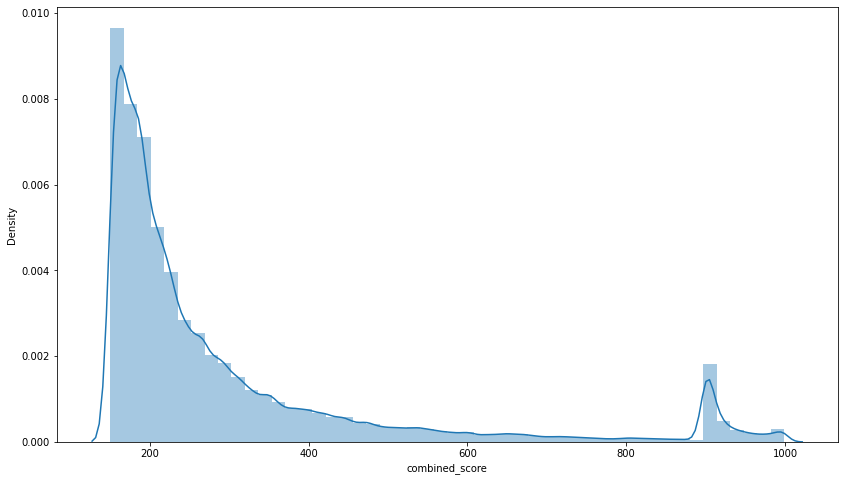

In [4]:
fig = plt.figure(figsize=(14, 8))
sns.distplot(string_ppis.combined_score)

In [ ]:
high_conf_string_ppis = string_ppis[string_ppis.combined_score >= 200].copy()
high_conf_string_ppis.loc[:, 'protein1'] = [i[1] for i in high_conf_string_ppis.protein1.str.split('.')]
high_conf_string_ppis.loc[:, 'protein2'] = [i[1] for i in high_conf_string_ppis.protein2.str.split('.')]

In [6]:
ens_names = high_conf_string_ppis.protein1.append(high_conf_string_ppis.protein2).unique()
ens_to_symbol = get_gene_symbols_from_proteins(ens_names)

1 input query terms found dup hits:	[('ENSP00000473163', 3)]
871 input query terms found no hit:	['ENSP00000035383', 'ENSP00000062104', 'ENSP00000074304', 'ENSP00000155858', 'ENSP00000195455', 'ENS


In [7]:
p1_incl = high_conf_string_ppis.join(ens_to_symbol, on='protein1', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(ens_to_symbol, on='protein2', how='inner', rsuffix='_p2')
string_edgelist_symbols = both_incl.drop(['protein1', 'protein2'], axis=1)
string_edgelist_symbols.columns = ['confidence', 'partner1', 'partner2']
string_ppi_final = string_edgelist_symbols[['partner1', 'partner2', 'confidence']]

In [8]:
string_ppi_final

,partner1,partner2,confidence
0,ARF5,CALM2,490
2199,FKBP4,CALM2,196
8126,CYP51A1,CALM2,234
10464,PDK4,CALM2,155
12641,RALA,CALM2,395
...,...,...,...
10817986,FAM90A1,FAM90A26,400
11044313,DUX4,LOC102723655,556
11353249,DYNLL2,REDIC1,246
11353562,DYNLL2,SEPTIN4,212


In [9]:
G = nx.from_pandas_edgelist(string_ppi_final, source='partner1', target='partner2', edge_attr='confidence')
G.remove_edges_from(nx.selfloop_edges(G))
adj_pd = nx.to_pandas_adjacency(G)
adjacency_matrix = adj_pd.values
node_names = adj_pd.index.values

avg_node_degree = np.mean([value for key, value in G.degree()])
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges and {} nodes in total".format(G.number_of_edges(), G.number_of_nodes()))

Constructed Adjacency Matrix with average node degree of: 592.0440413092181
Adjacency matrix has 5417499 edges and 18301 nodes in total


In [10]:
high_conf_edgelist_no_repeat = nx.to_pandas_edgelist(G)
high_conf_edgelist_no_repeat.columns=['partner1','partner2','confidence']
high_conf_edgelist_no_repeat.to_csv('string_symbols_edgelist_no_repeat.tsv', sep='\t', index=False)
high_conf_edgelist_no_repeat

,partner1,partner2,confidence
0,ARF5,CALM2,490
1,ARF5,ARHGEF9,198
2,ARF5,ERN1,159
3,ARF5,CDKN2A,606
4,ARF5,P4HB,167
...,...,...,...
5417494,DEFB135,DEFB116,903
5417495,LDLRAD2,GAGE12E,400
5417496,DEFB116,DEFB136,903
5417497,PRR20E,PRR20B,771


D:\devtool\Anaconda3\envs\EMOGI-tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Node Degree Distribution of Genes in PPI')

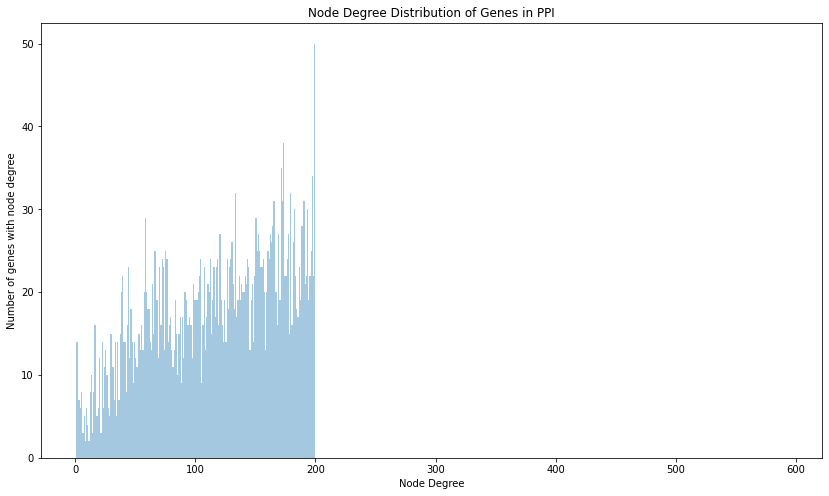

In [11]:
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 200, 200)

sns.distplot(node_degrees, kde=False, bins=bins) 

#ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

In [12]:
df=pd.DataFrame(node_degrees,columns=['node degree'])
df.describe().astype(int)

,node degree
count,18301
mean,592
std,504
min,1
25%,243
50%,460
75%,793
max,7365
